In [ ]:
#importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
#Loading the dataset
elecom_f = pd.read_csv('Electric_Production.csv' , parse_dates=['DATE'] , index_col='DATE')

In [ ]:
elecom = elecom_f[:288]

In [ ]:
elecom_test = elecom_f[288:]

In [ ]:
elecom.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1985-01-01 to 2008-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   283 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


In [ ]:
#Checking for null values
elecom.isnull().sum()

Value    5
dtype: int64

In [ ]:
elecom.tail()

,Value
DATE,
2008-08-01,107.5665
2008-09-01,97.7183
2008-10-01,90.9979
2008-11-01,93.8057
2008-12-01,109.4221


### Dealing with Missing Observations

In Time Series Analysis, we cannot impute the missing values with global mean or median because the time series data might have some seasonality or trend and therefore, these methods can cause biasness to the data.
Rather we would be using the interpolate function for imputations. Linear Interpolation simply means to estimate a missing value by connecting dots in a straight line in increasing order. In short, It estimates the unknown value in the same increasing order from previous values. The default method used by Interpolation is Linear. So while applying it, we need not specify it.

In [ ]:
elecom_inter = elecom.interpolate(method='linear')

In [ ]:
#Checking for null values
elecom_inter.isnull().sum()

Value    0
dtype: int64

In [ ]:
elecom_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1985-01-01 to 2008-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   288 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


<Axes: xlabel='DATE'>

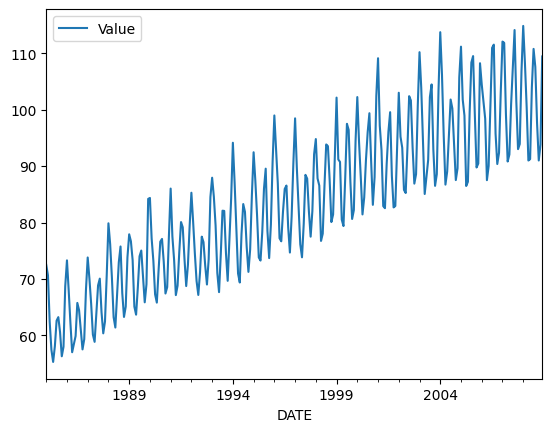

In [ ]:
elecom_inter.plot()

Before proceeding towards Time Series Decomposition, we need to decide weather the model is Additive or Multiplicative. We observe that the magnitude of seasional fluctuations increases over time, hence it is a Multiplicative model. Now, we can convert a Multiplicative Model into a Additive Model by simply taking the logarithms of the observations.

In [ ]:
data = np.log(elecom_inter.copy())
data['Value'] = np.log(elecom_inter['Value'])

<Axes: xlabel='DATE'>

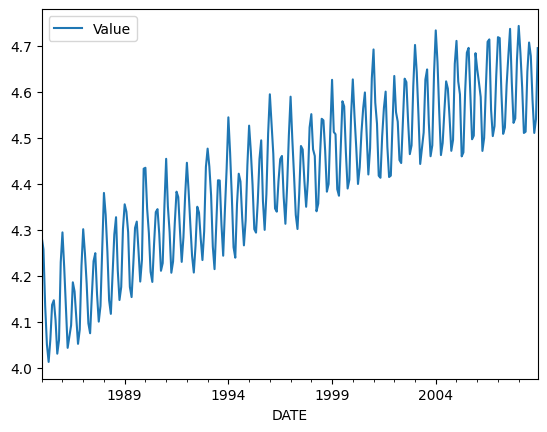

In [ ]:
data.plot()

In [ ]:
data1 =data['Value']-data['Value'].shift(12)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def rltv_oderng_test(y):
    cnt = 0
    for i in range(len(y) - 1):
        for j in range(i + 1, len(y)):
            if y[i] > y[j]:
                cnt += 1  # cnt is q in the test

    exp_q = len(y) * (len(y) - 1) / 4
    tau = (1 - (4 * cnt)) / (len(y) * (len(y) - 1))
    V_tau = 2 * (2 * len(y) + 5) / ((9 * len(y) * (len(y) - 1)))
    tst_stat = tau / np.sqrt(V_tau)
    z_alpha = norm.ppf(0.025)
    print(tst_stat)

    if abs(tst_stat) > abs(z_alpha):
        print("Reject Null Hypothesis")
    else:
        print("Accept Null Hypothesis")


In [ ]:
rltv_oderng_test(data['Value'])

-8.029635771275773
Reject Null Hypothesis


In [ ]:
import numpy as np
from scipy.stats import chi2

def calc_chi(m, c, r):
    x = 0
    den = c * (r + 1)
    num = c * (r + 1) * 0.5
    for i in range(r):
        x += (m[i] - num) ** 2
    return x / den

def sesnlty_check(y):
    dt_mtrx = np.array(y).reshape((12, -1))
    dt_rankedmtrx = np.zeros_like(dt_mtrx)

    for i in range(dt_mtrx.shape[1]):
        dt_rankedmtrx[:, i] = np.argsort(dt_mtrx[:, i]) + 1

    m_i = np.sum(dt_rankedmtrx, axis=1)
    chi = calc_chi(m_i, dt_mtrx.shape[1], dt_mtrx.shape[0])

    tab_Chi = chi2.ppf(0.95, dt_mtrx.shape[0] - 1)

    print(chi , tab_Chi)
    if chi > tab_Chi:
        print("Data shows the presence of seasonality.")
    else:
        print("Based on the data, we may not say that there is the presence of seasonality.")


In [ ]:
sesnlty_check(data['Value'])

260.35897435897436 19.67513757268249
Data shows the presence of seasonality.


### Time Series Decomposition :

###### Time series decomposition is a technique used to break down a time series into its underlying components:
1) Trend: The trend component represents the long-term direction or movement of the time series.
2) Seasonality: The seasonality component represents the repetitive patterns or fluctuations that occur within a fixed period, such as daily, weekly, monthly, or yearly.
3) Residual (or Error): The residual component represents the remaining variation in the data that cannot be attributed to the trend or seasonality. It includes any random or unpredictable fluctuations

In [ ]:
decomposition = seasonal_decompose(data['Value'] , model= 'additive')

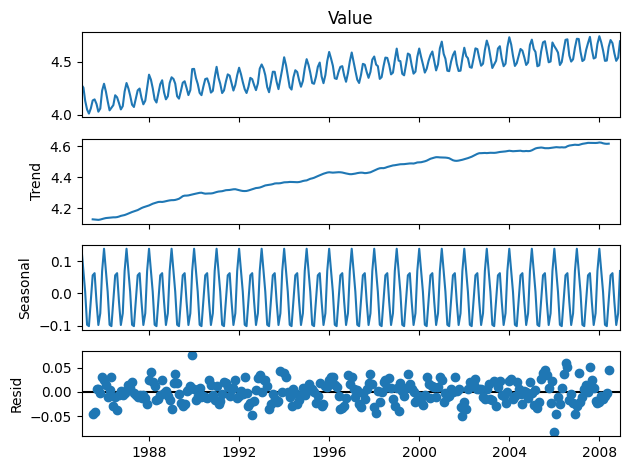

In [ ]:
plot = decomposition.plot()

<Axes: xlabel='DATE'>

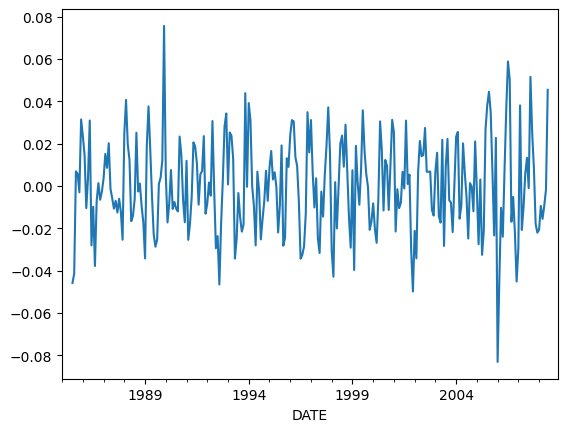

In [ ]:
resid = decomposition.resid
resid.plot()

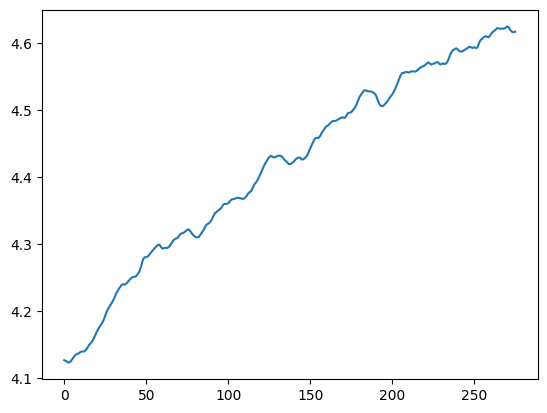

In [ ]:
m = np.zeros(len(data) - 12)
for i in range(6, len(data) - 6):
    m[i-6] = (1/12) * ((0.5) * data['Value'][i-6] + data['Value'][i-5] + data['Value'][i-4] + data['Value'][i-3] + data['Value'][i-2] + data['Value'][i-1] + data['Value'][i] + data['Value'][i+1] + data['Value'][i+2] + data['Value'][i+3] + data['Value'][i+4] + data['Value'][i+5] + (0.5) * data['Value'][i+6])
plt.plot(m)

In [ ]:
m1 = [m[0] , m[0] ,m[0] ,m[0] ,m[0] ,m[0] ]
m2 = [m[275] , m[275] ,m[275] ,m[275] ,m[275] ,m[275] ]

In [ ]:
m_all = np.concatenate((m1 , m , m2))

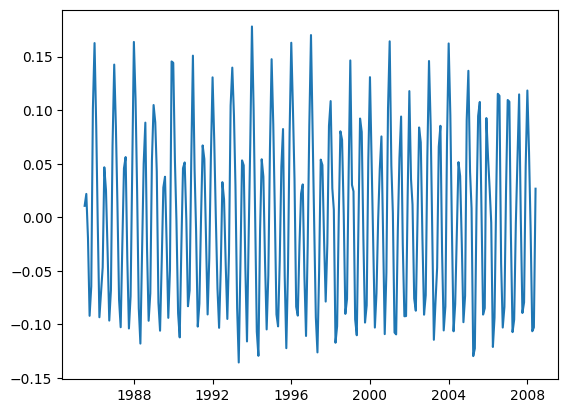

In [ ]:
x = data['Value'][6:-6] - m

# Plot the result
plt.plot(x)

In [ ]:
d = 12
q = 6
w = np.zeros(d)
for k in range(1, d+1):
    s = 0
    for j in range(1, 25):
        s += data['Value'][d*(j-1) + k - 1] - m_all[d*(j-1) + k - 1]
    w[k-1] = s

w2 = w / 24


s = w2 - np.mean(w2)
print("Seasonal Component (s):", s)

Seasonal Component (s): [ 0.13956153  0.07220912  0.00513986 -0.09651352 -0.10212277 -0.02090109
  0.05762508  0.06286529 -0.02697887 -0.09846976 -0.06242768  0.07001282]


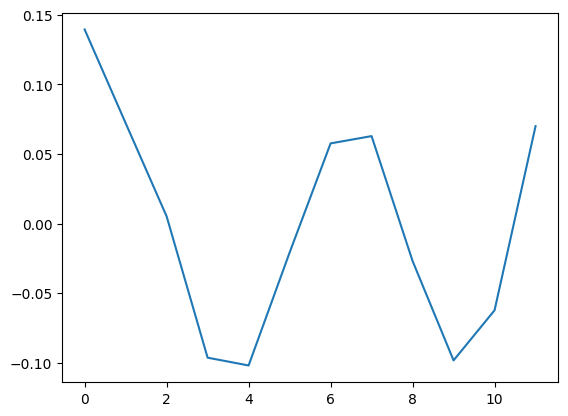

In [ ]:
plt.plot(s)

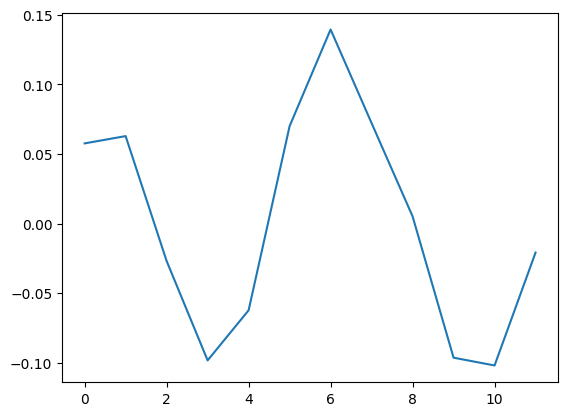

In [ ]:
sc = np.zeros(12)

# Shifting elements and wrapping around
for i in range(1, 13):
    if i <= 6:
        sc[i - 1] = s[5 + i]
    else:
        sc[i - 1] = s[i - 7]
plt.plot(sc)

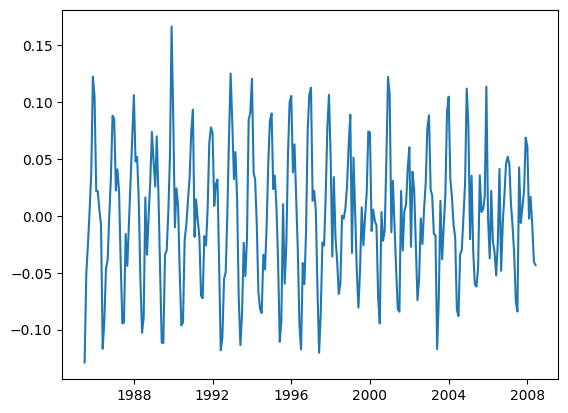

In [ ]:
season =  np.tile(s , 23)
random = x - season
plt.plot(random)

In [ ]:
def adfuller_test(x):
    result = adfuller(x)
    labels = ['ADF Test Statistic' , 'p-value' , '#Lags Used' , 'Number of Observations Used']
    for value,label in zip(result , labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("reject null hypothesis")
    else:
        print("accept null hypothesis")

In [ ]:
adfuller_test(resid.dropna())

ADF Test Statistic : -7.5784783254009955
p-value : 2.7214742116272785e-11
#Lags Used : 14
Number of Observations Used : 261
reject null hypothesis


In [ ]:
k = range(0 , 11)
h = len(k)
n = len(resid)
q1 = 0
ts = pd.Series(resid)
for i in range(h):
    q1 += ts.autocorr(lag = k[i] )/(n - k[i])
Q = n*(n + 2)*q1
Q

84.0947058182374

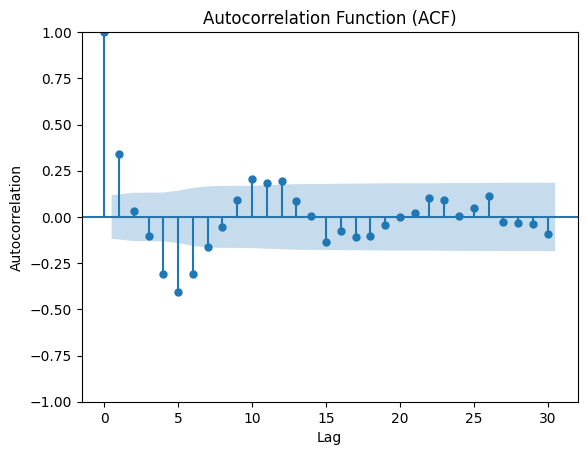

In [ ]:
#plot of ACF

plot_acf(resid.dropna(), lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

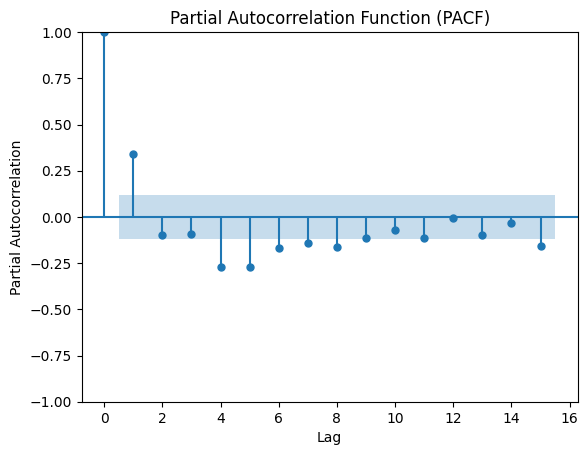

In [ ]:
#plot of PACF

plot_pacf(resid.dropna(), lags= 15
         )
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

### Fitting of ARMA Model

In [ ]:
    for j in range(30):
        k = ARIMA(data['Value'], order=(j, 0 , 0)).fit()
        print(j , k.aic)

0 -200.56375411818297
1 -646.4026612230648
2 -710.9488148476403
3 -847.2349288876442
4 -946.6639026003252
5 -994.1798674204484
6 -991.7517223644563
7 -992.3424925253003
8 -992.8769116000863
9 -1006.7077897792344
10 -1048.6640773382342
11 -1116.3782076481912
12 -1148.8662772267298
13 -1203.2088347006027
14 -1209.9208383202795
15 -1215.4058623172755
16 -1214.4800493374703
17 -1212.8638780301749
18 -1212.3332816618947
19 -1210.576145793146
20 -1209.5913052453284
21 -1208.5219533765123
22 -1205.4738575153935
23 -1171.4665912988394
24 -1186.6635393999313
25 -1186.047913813239
26 -1173.1512590366985
27 -1170.5240083932204
28 -1177.8630265612278
29 -1166.0774603591326


In [ ]:
# Create an instance of the ARMA model with appropriate order values
import statsmodels.api as sm

ma = ARIMA(resid, order=(0, 0 , 5))  # Replace p and q with desired order values

# Fit the model to the data
ma_fit = ma.fit()

predictions_ma = ma_fit.predict(start= 0, end=len(resid))
forcast_ma = ma_fit.forecast(steps=25)

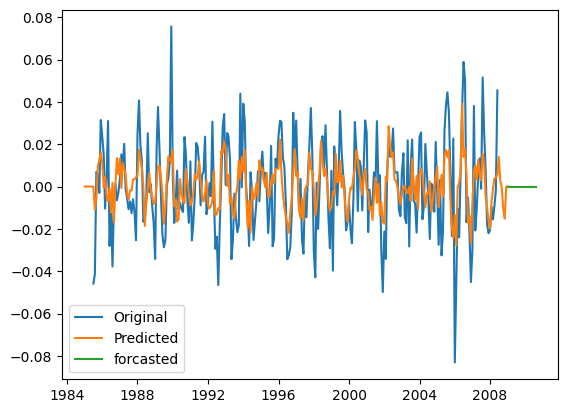

In [ ]:
plt.plot(resid, label='Original')
plt.plot(predictions_ma, label='Predicted')
plt.plot(forcast_ma, label='forcasted')
plt.legend()
plt.show()

In [ ]:
residuals = np.array(resid) - np.array(predictions_ma[1:])
rmse = np.sqrt(np.nanmean(residuals**2))
np.nanmean(residuals)

-0.0003194646879571602

In [ ]:
# Create an instance of the ARMA model with appropriate order values
import statsmodels.api as sm

arma = ARIMA(resid, order=(4, 0 , 5))  # Replace p and q with desired order values

# Fit the model to the data
arma_fit = arma.fit()

In [ ]:
predictions_arma = arma_fit.predict(start= 0, end=len(resid))
forcast_arma = arma_fit.forecast(steps=25)

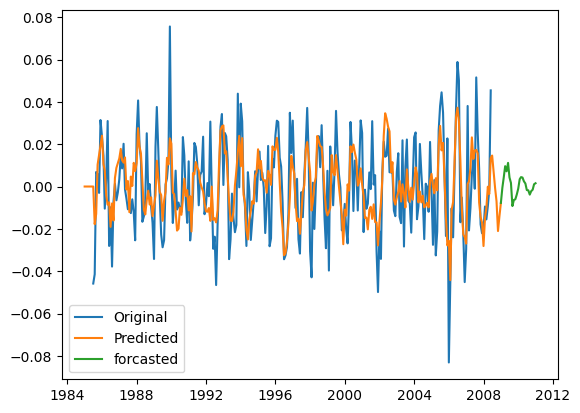

In [ ]:
plt.plot(resid, label='Original')
plt.plot(predictions_arma, label='Predicted')
plt.plot(forcast_arma, label='forcasted')
plt.legend()
plt.show()

In [ ]:
arma_fit.aic

-1422.2290827884628

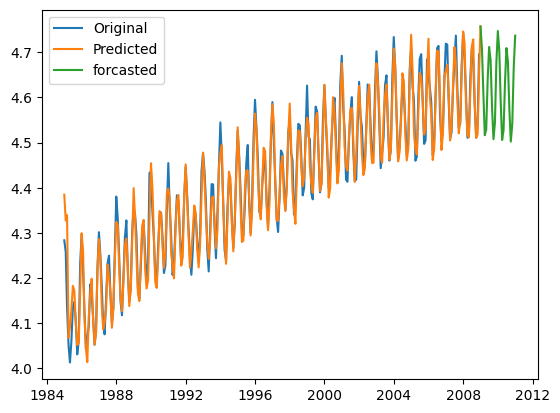

In [ ]:
# Create an instance of the ARMA model with appropriate order values
import statsmodels.api as sm

arma_orig = ARIMA(data['Value'], order=(4, 0 , 5))  # Replace p and q with desired order values

# Fit the model to the data
arma_fit_orig = arma_orig.fit()

predictions_arma_orig = arma_fit_orig.predict(start= 0, end=len(resid))
forcast_arma_orig = arma_fit_orig.forecast(steps=25)

plt.plot(data['Value'], label='Original')
plt.plot(predictions_arma_orig, label='Predicted')
plt.plot(forcast_arma_orig, label='forcasted')
plt.legend()
plt.show()

In [ ]:
2.718**forcast_arma_orig

2009-01-01    116.361040
2009-02-01    110.577532
2009-03-01    100.672019
2009-04-01     91.456816
2009-05-01     92.586153
2009-06-01    103.483579
2009-07-01    111.197271
2009-08-01    108.014334
2009-09-01     97.190243
2009-10-01     90.668647
2009-11-01     94.076282
2009-12-01    107.454723
2010-01-01    115.198396
2010-02-01    110.150830
2010-03-01     98.852457
2010-04-01     90.500481
2010-05-01     92.446962
2010-06-01    102.847201
2010-07-01    110.925131
2010-08-01    107.684062
2010-09-01     96.689009
2010-10-01     90.178790
2010-11-01     93.783239
2010-12-01    106.086579
2011-01-01    114.031649
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
elecom_test[:10]

,Value
DATE,
2009-01-01,116.8316
2009-02-01,104.4202
2009-03-01,NaN
2009-04-01,88.1973
2009-05-01,87.5366
2009-06-01,97.2387
2009-07-01,103.9086
2009-08-01,105.7486
2009-09-01,94.8823


In [ ]:
import numpy as np
from scipy.stats import norm

def trn_pt_tst(y):
    cnt = 0
    for i in range(1, len(y) - 1):
        if ((y[i] > y[i + 1] and y[i] > y[i - 1]) or (y[i] < y[i + 1] and y[i] < y[i - 1])):
            cnt += 1

    exp_T = (2 / 3) * (len(y) - 2)
    V_T = (16 * len(y) - 29) / 90
    tst_stat = (cnt - exp_T) / np.sqrt(V_T)
    z_alpha = norm.ppf(0.025)
    print(tst_stat)
    if abs(tst_stat) > abs(z_alpha):
        print("On the basis of the given data, we may not accept our Null Hypothesis so we have to accept our Alternative hypothesis")
    else:
        print("On the basis of the given data, we may accept our Null Hypothesis")

In [ ]:
trn_pt_tst(data['Value'])

-13.412093580197487
On the basis of the given data, we may not accept our Null Hypothesis so we have to accept our Alternative hypothesis
